# Plot data

In [1]:
# Load data:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
data_train=pd.read_excel("DST_BIL54_train.xlsx",header=None)
list_of_drive = data_train.iloc[1].values


/tmp/ipykernel_27814/901208313.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Create new column with time variable:
list_of_drive = list_of_drive[1:]

time = np.array([2018+1/12 * i for i in range(0, len(list_of_drive))])

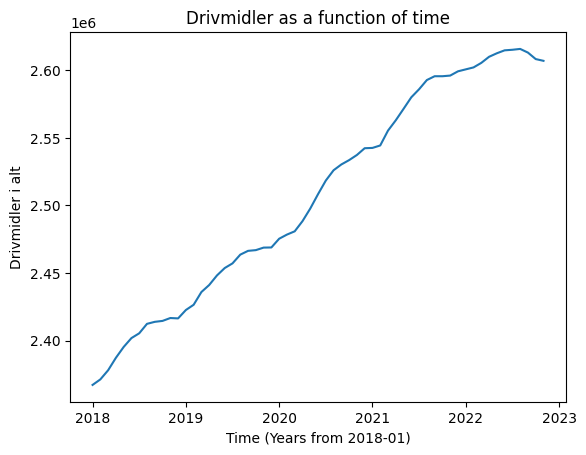

In [3]:

plt.plot(time,list_of_drive)
plt.title('Drivmidler as a function of time')
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.savefig("plot_data.png")

Notes
- Seems to be globally increasing somewhat linearly, stagnates towards the end and seems to be a slight seasonality. 

# OLS

In [4]:
# calculate the parameters of an OLS regression:

# stack  with a columnn of ones:
data = np.array(list_of_drive)
time_inter = np.vstack((np.ones(len(time)), time.T)).T

# Calculate the parameters:
beta = np.linalg.inv(time_inter.T @ time_inter) @ time_inter.T @ data

In [5]:
beta

array([-109499932.75338264, 55437.78301683211], dtype=object)

In [6]:
# estimate the errors of the parameters:

# calculate the residuals:
residuals = data - time_inter @ beta

# calculate the variance of the residuals:
variance = residuals.T @ residuals / (len(time) - 2)

# calculate the variance of the parameters:
var_beta = variance * np.linalg.inv(time_inter.T @ time_inter)

# calculate the standard deviation of the parameters:
std_beta = np.sqrt(np.diag(var_beta))

std_beta

array([1.92155555e+06, 9.51068713e+02])

In [7]:
# forcastt of the drivmidler 
x_forcast = np.array([np.max(time)+1/12*i for i in range (1, 13)])
x_forcast = np.vstack((np.ones(len(x_forcast)), x_forcast.T)).T
y_forcast = x_forcast @ beta

# calculate the confidence interval:
t = stats.t.ppf(0.90, len(time) - 2)

# calculate the vmatrix based on variance and the x_forcast matrix:
vmatrix = variance * (1+x_forcast @ np.linalg.inv(time_inter.T @ time_inter) @ x_forcast.T)
y_forcast_upper = y_forcast + t * np.sqrt(np.diag(vmatrix))
y_forcast_lower = y_forcast - t * np.sqrt(np.diag(vmatrix))


In [8]:
x_forcast

array([[1.00000000e+00, 2.02291667e+03],
       [1.00000000e+00, 2.02300000e+03],
       [1.00000000e+00, 2.02308333e+03],
       [1.00000000e+00, 2.02316667e+03],
       [1.00000000e+00, 2.02325000e+03],
       [1.00000000e+00, 2.02333333e+03],
       [1.00000000e+00, 2.02341667e+03],
       [1.00000000e+00, 2.02350000e+03],
       [1.00000000e+00, 2.02358333e+03],
       [1.00000000e+00, 2.02366667e+03],
       [1.00000000e+00, 2.02375000e+03],
       [1.00000000e+00, 2.02383333e+03]])

In [9]:
y_forcast

array([2646082.474417314, 2650702.289668724, 2655322.104920119,
       2659941.920171514, 2664561.735422924, 2669181.5506743193,
       2673801.3659257293, 2678421.1811771393, 2683040.9964285344,
       2687660.8116799295, 2692280.6269313395, 2696900.4421827346],
      dtype=object)

In [10]:
y_forcast_lower

array([2632181.1601474653, 2636777.8258170416, 2641373.7728146384,
       2645969.004823134, 2650563.52560947, 2655157.3390219584,
       2659750.448987707, 2664342.8595098224, 2668934.574664744,
       2673525.5985995517, 2678115.935529206, 2682705.5897337683],
      dtype=object)

In [11]:
y_forcast_lower

array([2632181.1601474653, 2636777.8258170416, 2641373.7728146384,
       2645969.004823134, 2650563.52560947, 2655157.3390219584,
       2659750.448987707, 2664342.8595098224, 2668934.574664744,
       2673525.5985995517, 2678115.935529206, 2682705.5897337683],
      dtype=object)

In [12]:
# load the test data:

data_test=pd.read_excel("DST_BIL54_test.xlsx",header=None)
data_test = data_test.iloc[1].values
data_test = data_test[1:]

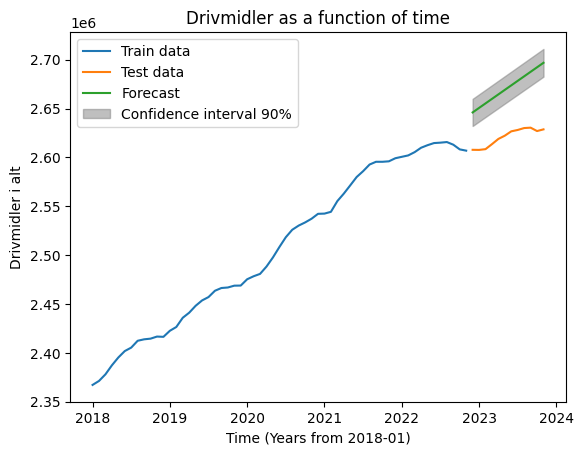

In [14]:
# plot the forecast data with the old data:
x_values = x_forcast[:,1]
plt.plot(time,list_of_drive)
plt.plot(x_values,data_test)
plt.plot(x_values,y_forcast)
plt.fill_between(x_values,list(y_forcast_lower),list(y_forcast_upper), color='gray', alpha=0.5)
plt.legend(["Train data",'Test data','Forecast','Confidence interval 90%'])
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.title('Drivmidler as a function of time')
plt.savefig('forecastOLS.png')


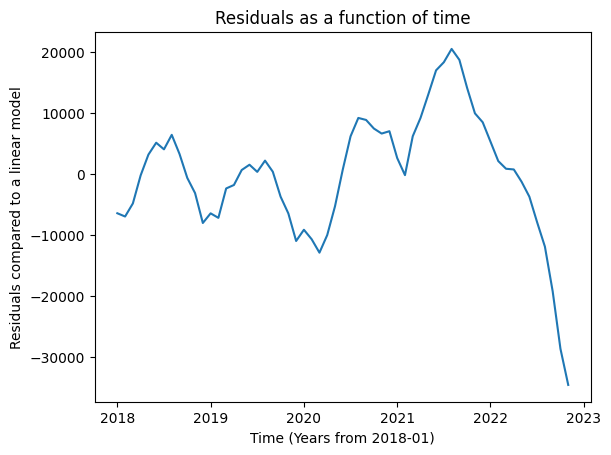

In [15]:
# investigate residuals:
plt.plot(time,residuals)
plt.title('Residuals as a function of time')
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Residuals compared to a linear model')
plt.savefig('residuals.png')

# WLS

We will now use WLS to make the linear model in Eq. (1) as a local trend model, i.e., the observation
at the latest timepoint (xN = x59 = 2022.833) has weight λ0 = 1, the observation at the second
latest timepoint (xN −1 = x58 = 2022.750) has weight λ1 , the third latest observation (xN −2 = x57 =
2022.667) has weight λ2 etc.
We start by setting λ = 0.9.

In [ ]:
# Creating the Sigma matrix for WLS
lamb = 0.9
Sigma = np.zeros((len(time),len(time)))
for i in range(len(time)):
    Sigma[i,i] = 1/(lamb**(len(time)-i))


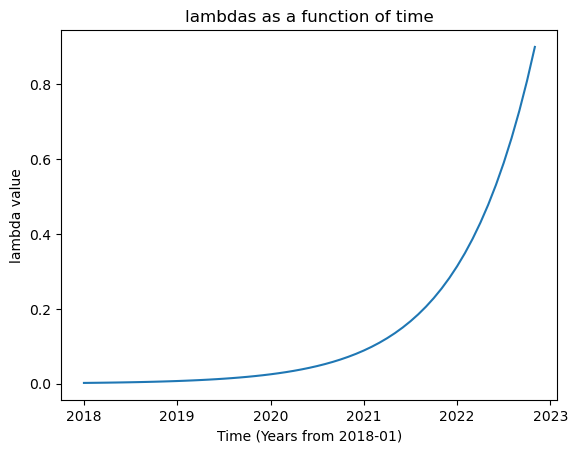

In [ ]:
# Plot diagonals as a function of time: 

plt.plot(time,1/np.diag(Sigma))
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('lambda value')
plt.title("lambdas as a function of time")
plt.savefig("WLSLambdasVsTime.png")

In [ ]:
np.sum(1/np.diag(Sigma))

8.982029897000858

In [ ]:
#calculate the parameters: 

beta_WLS = np.linalg.inv(time_inter.T @ np.linalg.inv(Sigma) @ time_inter) @ time_inter.T @ np.linalg.inv(Sigma) @ data
beta_WLS

array([-84089781.0259155, 42868.564479107794], dtype=object)

In [ ]:
# make prediction: 
y_pred_WLS_09 = x_forecase @ beta_WLS

array([2629752.5349462926, 2633324.915319562, 2636897.2956928164,
       2640469.676066071, 2644042.05643934, 2647614.4368125945,
       2651186.817185849, 2654759.1975591183, 2658331.5779323727,
       2661903.958305627, 2665476.3386788964, 2669048.719052151],
      dtype=object)

In [ ]:
legend = []
for lamb in  [0.9,0.8,0.7,0.6]:
    Sigma = np.zeros((len(time),len(time)))
    for i in range(len(time)):
        Sigma[i,i] = 1/(lamb**(len(time)-i))
    
    beta_WLS = np.linalg.inv(time_inter.T @ np.linalg.inv(Sigma) @ time_inter) @ time_inter.T @ np.linalg.inv(Sigma) @ data
    y_pred_WLS = x_forecase @ beta_WLS
    plt.plot(x_values,y_pred_WLS)
    legend.append(f"WLS_pred_lambda {lamb}")

plt.plot(time,list_of_drive)
plt.legend()

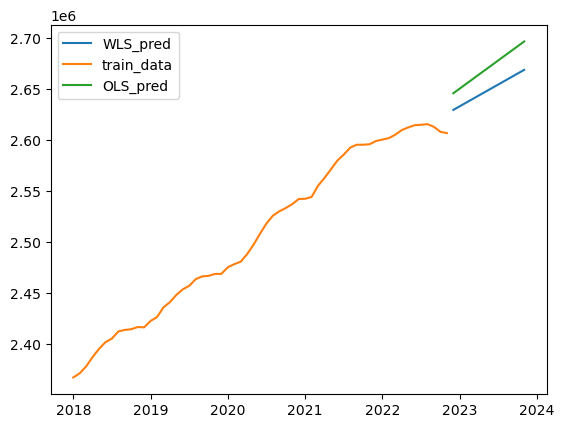

In [ ]:

plt.plot(x_values,y_pred_WLS)
plt.plot(time,list_of_drive)
plt.plot(x_values,y_forecase)
plt.legend(["WLS_pred","train_data","OLS_pred"])